In [1]:
!pip install bitsandbytes
!pip install peft
!pip install accelerate
!pip install datasets
!pip install trl

In [2]:
import torch
import bitsandbytes as bnb
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tqdm.auto import tqdm
from transformers import (AutoTokenizer, AutoModelForCausalLM,
                          AutoModelForSequenceClassification, AutoModel,
                          pipeline, BitsAndBytesConfig, Trainer,
                          TrainingArguments, DataCollatorForLanguageModeling,
                          DataCollatorWithPadding, TrainerCallback,
                          EarlyStoppingCallback, GenerationConfig)
from huggingface_hub.hf_api import HfFolder
from transformers.pipelines.pt_utils import KeyDataset
from peft import (LoraConfig, get_peft_model, prepare_model_for_kbit_training,
                  PeftModel, AutoPeftModelForCausalLM)
from sklearn.metrics import confusion_matrix, classification_report
from datasets import load_dataset, Dataset
from trl import SFTTrainer
from functools import partial
from copy import deepcopy

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!python -c "from huggingface_hub.hf_api import HfFolder; HfFolder.save_token('hf_XXXXXXXXXXXXXXXXXXXXX')"

In [5]:
df = pd.read_csv('/content/drive/MyDrive/las_vegas_airbnb_data.csv')

In [6]:
df.head()

,roomType,stars,address,numberOfGuests,primaryHost/smartName,price,firstReviewComments,firstReviewRating
0,Entire condo,4.54,"Las Vegas, Nevada, United States",4,Doug,NaN,"Overall, I had a good experience. The only dow...",4.0
1,Entire rental unit,4.39,"Las Vegas, Nevada, United States",4,Doug,NaN,I stayed an extra night. That should sum it up...,5.0
2,Entire guest suite,NaN,"Las Vegas, Nevada, United States",4,Aaron&Tina,NaN,These days things are so impersonable but she ...,5.0
3,Entire condo,NaN,"Las Vegas, Nevada, United States",6,Aaron&Tina,NaN,Great response time from owner. Could message ...,5.0
4,Private room in home,4.51,"Las Vegas, Nevada, United States",2,Brad,NaN,good group of guys in the house. quiet clean a...,5.0


# EDA

In [7]:
df.shape

(1000, 8)

In [8]:
df.isnull().sum()

roomType                    0
stars                     277
address                     0
numberOfGuests              0
primaryHost/smartName       0
price                    1000
firstReviewComments       205
firstReviewRating         205
dtype: int64

In [9]:
# dropping price as it is all missing
# dropping name of host
df.drop(columns=['price', 'primaryHost/smartName'],inplace=True)

In [10]:
# drop rows associated with other missing values as will need the info for finetuning
df.dropna(inplace=True)

In [11]:
df['length'] = df['firstReviewComments'].apply(lambda x: len(x.split()))

max_len = df['length'].max()
print(max_len)

259


Text(0.5, 1.0, 'Boxplot of Text Length by review rating')

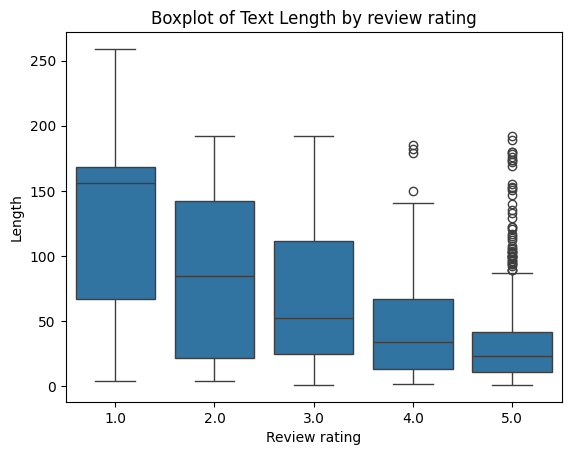

In [12]:
sns.boxplot(x='firstReviewRating', y='length', data=df)

plt.xlabel('Review rating')
plt.ylabel('Length')
plt.title('Boxplot of Text Length by review rating')

In [13]:
df.drop(columns=['length'], inplace=True)

In [14]:
df.roomType.value_counts()

Entire home                        265
Entire condo                       175
Entire rental unit                  49
Entire serviced apartment           47
Private room in home                39
Entire villa                        32
Entire guest suite                  26
Private room in resort              24
Room in hotel                       18
Entire townhouse                     8
Entire guesthouse                    7
Private room in rental unit          4
Private room in guest suite          3
Entire bungalow                      3
Private room in townhouse            3
Private room in guesthouse           3
Private room in condo                2
Camper/RV                            2
Private room in villa                2
Tiny home                            2
Room in boutique hotel               2
Entire loft                          1
Private room in casa particular      1
Room in serviced apartment           1
Private room in bungalow             1
Room in aparthotel       

# Prepare Data

In [15]:
data = Dataset.from_pandas(df)

In [16]:
data

Dataset({
    features: ['roomType', 'stars', 'address', 'numberOfGuests', 'firstReviewComments', 'firstReviewRating', '__index_level_0__'],
    num_rows: 723
})

# Load Model

In [17]:
# Reducing size (and precision) of model
bnb_config = BitsAndBytesConfig(
        load_in_4bit = True,
        bnb_4bit_use_double_quant = True,
        bnb_4bit_quant_type = "nf4",
        bnb_4bit_compute_dtype = torch.bfloat16,
    )

In [38]:
model_id = "google/gemma-2b-it"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config = bnb_config,
    device_map = "auto", # dispatch the model efficiently on the available resources
)

tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [19]:
# Function to submit and encode a query for Gemma response generation
def get_completion(query: str, model, tokenizer) -> str:
    device = "cuda:0"

    prompt_template = """
    <start_of_turn>user
    Below is an instruction that describes a task. Write a response that appropriately completes the request.
    {query}
    <end_of_turn>\n<start_of_turn>model


    """
    prompt = prompt_template.format(query=query)

    encodeds = tokenizer(prompt, return_tensors="pt", add_special_tokens=True)

    model_inputs = encodeds.to(device)


    generated_ids = model.generate(**model_inputs, max_new_tokens=1000, do_sample=True, pad_token_id=tokenizer.eos_token_id)
    # decoded = tokenizer.batch_decode(generated_ids)
    decoded = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return (decoded)

In [20]:
result = get_completion(query="Write me a 4 star Airbnb review for an Entire home that holds 4 guests.", model=model, tokenizer=tokenizer)
print(result)


  user
  Below is an instruction that describes a task. Write a response that appropriately completes the request.
  Write me a 4 star Airbnb review for an Entire home that holds 4 guests.
  
model
  

  **5/5 Stars!** 

This entire home was a delight to stay in! From the cozy living room to the well-equipped kitchen, everything was just as described. The bedrooms were spacious and comfortable, with ample room for four guests. The outdoor space was fantastic - perfect for grilling, reading, or simply relaxing in the sunshine. 

The host was incredibly responsive and helpful, always available to answer any questions or concerns we had. The location was excellent - close to the beach, yet quiet and private. 

Overall, our stay at this home was unforgettable. We highly recommend it to anyone looking for a comfortable and stylish place to stay in the area!


In [40]:
result = get_completion(query="Write me a 1 star Airbnb review for a Private room in home that holds 2 guests.", model=model, tokenizer=tokenizer)
print(result)


  user
  Below is an instruction that describes a task. Write a response that appropriately completes the request.
  Write me a 1 star Airbnb review for a Private room in home that holds 2 guests.
  
model
  

  My stay in your private room in your home was wonderful! The space was spacious and comfortable, perfect for two people. The bed was comfortable, the bathroom was clean, and the location was quiet and safe. 
  
  I would highly recommend your property to others. The amenities were top-notch, and the location was perfect for exploring the city. 
  
  I will certainly be returning to stay with you in the future!


The review is quite generic and actually doesn't even reflect the 4 star review we have asked for. By fine-tuning to our data, we are hoping to make it more specific to the Vegas area.

# Define prompt template

In [22]:
def generate_prompt(data_point):
    """Gen. input text based on a prompt, task instruction, (context info.), and answer

    :param data_point: dict: Data point
    :return: dict: tokenzed prompt
    """
    prefix_text = 'Below is an instruction that describes a task. Write a response that ' \
               'appropriately completes the request.\n\n'
    # Samples with additional context into.
    text = f"""<start_of_turn>user {prefix_text} Write me a {data_point["firstReviewRating"]} Airbnb review for a {data_point["roomType"]} that holds {data_point["numberOfGuests"]} guests. <end_of_turn>\n<start_of_turn>model{data_point["firstReviewComments"]} <end_of_turn>"""
    return text

# add the "prompt" column in the dataset
text_column = [generate_prompt(data_point) for data_point in data]
data = data.add_column("prompt", text_column)

In [23]:
def preprocess_batch(batch, tokenizer):
    """
    Tokenizes dataset batch

    :param batch: Dataset batch
    :param tokenizer: Model tokenizer
    """

    return tokenizer(
        batch["prompt"]
    )

In [24]:
data['prompt'][0]

"<start_of_turn>user Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n Write me a 4.0 Airbnb review for a Entire condo that holds 4 guests. <end_of_turn>\n<start_of_turn>modelOverall, I had a good experience. The only downside would be that check in was a bit difficult. We got to the location we were sent, and was told at the gate that we were at the wrong location. After messaging the host, he let us know we would be going to a different location. After a long day of traveling, it was very inconvenient that we went to the wrong location. A little bit more communication would've went a long way. Also, some type of early check in or bag drop off would've helped a lot. We were told by a lot of people from the area that it is common for the flights that the times are very weird. You either are coming into Vegas very early in the morning or late at night. It was difficult finding flights close to check in. The apartment did not ma

In [25]:
data

Dataset({
    features: ['roomType', 'stars', 'address', 'numberOfGuests', 'firstReviewComments', 'firstReviewRating', '__index_level_0__', 'prompt'],
    num_rows: 723
})

In [26]:
data = data.shuffle(seed=1234)

preprocessing_function = partial(preprocess_batch, tokenizer = tokenizer)
data = data.map(preprocessing_function, batched = True, remove_columns = ['roomType', 'stars', 'address', 'firstReviewComments', 'firstReviewRating', '__index_level_0__'])

Map:   0%|          | 0/723 [00:00<?, ? examples/s]

## Additional utilities for fine-tuning

In [27]:
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm = False)

In [28]:
# Define trainable parameters
def find_all_linear_names(model):
    """
    Find modules to apply LoRA to.

    :param model: PEFT model
    """

    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:
        lora_module_names.remove('lm_head')
    print(f"LoRA module names: {list(lora_module_names)}")
    return list(lora_module_names)

# Fine tune the model

In [29]:
# Enable gradient checkpointing to reduce memory usage during fine-tuning
model.gradient_checkpointing_enable()

# Prepare the model for training
model = prepare_model_for_kbit_training(model)

# Get LoRA module names
target_modules = find_all_linear_names(model)

# Used for training only subset of parameters
config = LoraConfig(
    r=64,
    lora_alpha=32,
    target_modules=target_modules,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)

# Training parameters
torch.cuda.empty_cache()

trainer = SFTTrainer(
    model=model,
    train_dataset=data,
    dataset_text_field="prompt",
    peft_config=config,
    args=TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=0.03,
        max_steps=50,
        learning_rate=2e-4,
        logging_steps=1,
        output_dir="/content/drive/MyDrive/LLM",
        optim="paged_adamw_8bit",
        save_strategy="epoch",
    ),
    data_collator=data_collator,
)

model.config.use_cache = False

# Launch training and log metrics
print("Training...")

trainer.train()

# Save model
print("Saving last checkpoint of the model...")
trainer.model.save_pretrained("gemma-lasVegas-airbnb-tuned")

LoRA module names: ['o_proj', 'down_proj', 'v_proj', 'gate_proj', 'k_proj', 'up_proj', 'q_proj']


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:225: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/723 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:294: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


Training...


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
1,6.611800
2,6.499000
3,5.559800
4,3.941100
5,3.511400
6,3.095000
7,2.586300
8,2.253300
9,2.118000
10,2.114600


Saving last checkpoint of the model...


# Merge qLora weights and Base Model Weights

In [30]:
base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map={"": 0},
)
merged_model= PeftModel.from_pretrained(base_model, "gemma-lasVegas-airbnb-tuned")
merged_model= merged_model.merge_and_unload()

# Save the merged model
merged_model.save_pretrained("merged_model",safe_serialization=True)
tokenizer.save_pretrained("merged_model")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Compare outputs of base and finetuned model

In [33]:
result = get_completion(query="Write me a 4 star Airbnb review for a Entire home that holds 4 guests.", model=merged_model, tokenizer=tokenizer)
print(result)


  user
  Below is an instruction that describes a task. Write a response that appropriately completes the request.
  Write me a 4 star Airbnb review for a Entire home that holds 4 guests.
  
model
  

  A beautiful home for 4, easy access to the Strip.  Perfect for large families or groups.   
transportation is very convenient to anywhere you might want to go in the Vegas Strip area.  Would definitely recommend for any fun groups of 4!  
  Host was very friendly and responsive. The house was clean and spacious, beds made up of name comfy king bed and a pair of queen pull out beds and multiple sleeper sofas. 
  Would stay again.  
6 Guests 
412 S Highland Ave Las Vegas, NV 89102 
18.3/20 
  **Would come back again** modelThanks so much for this wonderful stay!  modelThe home was really nice and spacious. The house was clean and well kept on the inside.  pungkasnya‍ There is everything you need inside the house for any group or family to do. 
The host was very nice and responsive. Commu

In [37]:
result = get_completion(query="Write me a 1 star Airbnb review for a Private room in home that holds 2 guests.", model=merged_model, tokenizer=tokenizer)
print(result)


  user
  Below is an instruction that describes a task. Write a response that appropriately completes the request.
  Write me a 1 star Airbnb review for a Private room in home that holds 2 guests.
  
model
  

  Clean house, easy to get around to as it’s near the strip! 
🙄	
  Not the best location for a solo traveler. Too close to the strip with constant traffic noise that is extremely disruptive especially at night. Would not recommend!    lidl-v
  If you’re not able to take noise well or really don’t want to be in close proximity to others do not stay there! 
 🙃


The reviews output by the model are now much more specific to Vegas, the area for which the data is based on.